In [3]:
!pip install geopandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 117.5 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 99.6 kB/s eta 0:00:0000:0100:02m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.5/18.5 MB 191.1 kB/s eta 0:00:0000:0100:03
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 131.1 kB/s eta 0:00:00a 0:00:01


In [7]:
from meteostat import Point, Daily, Stations, Monthly
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path  
from tqdm import tqdm
import os
import geopandas as gpd

In [33]:
stations = Stations()
# PARAMETERS :
# Distance max au cas où un point random est trop loin d'une station :
distance_max = 100000
# Set time period :
start = datetime(1978, 1, 1)
end = datetime(2022, 12, 31)
# Create Points :
# MAT_x = np.arange(43.7, 50.4, 0.2)
MAT_x = np.arange(-60, 82, 1)
# MAT_y = np.arange(-4.5, 7.25, 0.2)
MAT_y = np.arange(-179, 180,1)
MAT = np.zeros((MAT_x.shape[0],MAT_y.shape[0], 2))
# print(MAT.shape)

In [34]:
## CREATION DE LA BDD REFERENCE : (avec toutes les stations qu'on va utiliser)

for x in range(MAT_x.shape[0]):
    for y in range(MAT_y.shape[0]):
        MAT[x, y] = (MAT_x[x], MAT_y[y])
# print(MAT)

# Create Point for all points in MAT
col_names = stations.nearby(0, 0).fetch(1).columns
loc_df = pd.DataFrame(columns=col_names)
for elt in MAT:
    for elt_bis in elt:
        stations = stations.nearby(elt_bis[0], elt_bis[1])
        # station_data = 
        station_name = stations.fetch(1)
        station_name = station_name[col_names]
        # print(station_name)
        loc_df = pd.concat([loc_df, station_name], ignore_index=True)

dist_df = pd.DataFrame(columns=["name", "distance"])
dist_df = loc_df.loc[:,["name", "distance"]]
#print(dist_df)
dist_df = dist_df.groupby("name").min()
#print(dist_df)
loc_df.drop("distance", axis=1, inplace=True)
#print(loc_df)
loc_df.drop_duplicates(inplace=True)
#print(loc_df)
loc_df = loc_df.join(dist_df,on='name')
#print(loc_df)
loc_df.drop(loc_df[loc_df.distance > distance_max].index, inplace=True)
#print(loc_df)
loc_df.drop(loc_df[loc_df.daily_start > start].index, inplace=True)
loc_df.drop(loc_df[loc_df.daily_end < end].index, inplace=True)
#print(loc_df)
loc_df.drop(["hourly_start", "hourly_end", "daily_start", "daily_end"], axis=1, inplace=True)
loc_df.dropna(inplace=True)

In [35]:
lati_list = list(loc_df["latitude"])
long_list = list(loc_df["longitude"])
loc_df

,name,country,region,wmo,icao,latitude,longitude,elevation,timezone,monthly_start,monthly_end,distance
328,Macquarie Island*,AU,TAS,94998,YMMQ,-54.5000,158.9000,6.0,Australia/Hobart,1950-01-01,2022-01-01,55966.607793
733,Chatham Island,NZ,CI,93986,NZCI,-43.9500,-176.5667,44.0,Pacific/Chatham,1950-01-01,1993-01-01,35115.815359
1535,Punta Arenas,CL,MA,85934,SCCI,-53.0000,-70.8500,37.0,America/Punta_Arenas,1967-01-01,2021-01-01,10037.814775
1903,Ushuaia Aerodrome,AR,V,87938,SAWH,-54.8000,-68.3167,16.0,America/Argentina/Ushuaia,1950-01-01,2021-01-01,49022.832059
2264,Rio Grande B. A.,AR,V,87934,SAWE,-53.8000,-67.7500,13.0,America/Argentina/Ushuaia,1975-01-01,2021-01-01,27619.542378
...,...,...,...,...,...,...,...,...,...,...,...,...
48186,Resolute Bay Airport,CA,NU,71924,CYRB,74.7200,-94.9700,68.0,America/Resolute,1947-01-01,2022-01-01,31146.766351
48216,Thule A. B.,GL,QS,04202,BGTL,76.5333,-68.7500,77.0,America/Thule,1951-01-01,2022-01-01,52283.268796
48634,Danmarkshavn,GL,UO,04320,BGDH,76.7667,-18.6667,11.0,America/Godthab,1958-01-01,2022-01-01,27270.976403
49608,Isachsen,CA,NU,71074,CWIC,78.7900,-103.5500,58.0,America/Cambridge_Bay,1948-01-01,2021-01-01,25261.466284


In [36]:
import folium

lati_list = list(loc_df["latitude"])
long_list = list(loc_df["longitude"])
m = folium.Map(location=[0, 10], zoom_start=2)

radius = 10000
sum=0
for lat,long in zip(lati_list,long_list):
    sum+=1
    folium.Circle(
        location=[lat,long],
        radius=radius,
        color="black",
        weight=1,
        fill_opacity=0.6,
        opacity=1,
        fill_color="blue",
        fill=False,  # gets overridden by fill_color
        popup="{} meters".format(radius),
        tooltip="I am in meters",
    ).add_to(m)
print(sum)
m

1315


In [37]:
a = loc_df[loc_df.country== "FR"]
print(a,len(a))

                       name country region    wmo  icao  latitude  longitude  \
36805               Ajaccio      FR      H  07761  LFKJ   41.9167     8.8000   
37156  Tarbes Ossun Lourdes      FR      N  07621  LFBT   43.1833     0.0000   
37157             St-Girons      FR      N  07627  LFCG   43.0000     1.1000   
37522                  Nice      FR      U  07690  LFMN   43.6500     7.2000   
37873   Bordeaux / Merignac      FR      B  07510  LFBD   44.8333    -0.7000   
38234               Limoges      FR     HV  07434  LFBL   45.8667     1.1833   
38236      Clermont-Ferrand      FR      C  07460  LFLC   45.7833     3.1667   
38592              Poitiers      FR      T  07335  LFBI   46.5833     0.3167   
38593                 Tours      FR      F  07240  LFOT   47.4500     0.7167   
38949                Rennes      FR      E  07130  LFRN   48.0667    -1.7333   
38955                Troyes      FR      G  07168  LFQB   48.3333     4.0167   
39310                  Caen      FR     

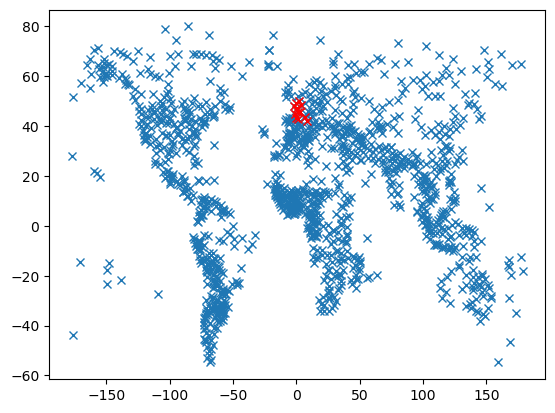

In [38]:
lati_list = list(loc_df["latitude"])
long_list = list(loc_df["longitude"])

lati_list_pays = list(a["latitude"])
long_list_pays = list(a["longitude"])

plt.plot(long_list,lati_list,'x',long_list_pays,lati_list_pays,'rx')

data = Daily(Point(50.5, 1.7), start, end)
data = data.fetch()

#path = Path(f"/Users/simontrottier/Documents/Polimi/Nonparametric stat/stat_project/Data/zzz.csv")
#data.to_csv(path)

In [39]:
def jours(mois):
    if mois==1:
        return 31
    if mois==2:
        return 28
    if mois==3:
        return 31
    if mois==4:
        return 30
    if mois==5:
        return 31
    if mois==6:
        return 30
    if mois==7:
        return 31
    if mois==8:
        return 31
    if mois==9:
        return 30
    if mois==10:
        return 31
    if mois==11:
        return 30
    if mois==12:
        return 31

In [43]:
# Dico
from pathlib import Path

lati_long_list = loc_df[["latitude", "longitude","name"]]
dico = dict()

path_dir = Path(f"/Users/noedebrois/Desktop/STAT_PROJET/NonParametricStatsProject/BDD_MONTHLY_WORLD")
os.mkdir(path_dir)

for idx in tqdm(range(len(lati_long_list))):
    try :
        a=tuple(lati_long_list.iloc[idx])[2].replace("/","_")
        # Set time period
        start = datetime(1978, 1, 1)
        end = datetime(2022, 12, 31)        
        data = Monthly(Point(tuple(lati_long_list.iloc[idx])[0], tuple(lati_long_list.iloc[idx])[1]), start, end)
        data = data.fetch()
        data.drop(["tsun",'wspd'], axis=1, inplace=True)
        path = Path(f"/Users/noedebrois/Desktop/STAT_PROJET/NonParametricStatsProject/BDD_MONTHLY_WORLD/Data_{a}.csv")
        data.to_csv(path)
    except :
        print(idx)

  0%|          | 0/1315 [00:00<?, ?it/s]

100%|██████████| 1315/1315 [00:43<00:00, 30.15it/s]


In [42]:
data

,tavg,tmin,tmax,prcp,pres
time,,,,,
1978-01-01,-36.7,-40.7,-32.7,1.0,1012.5
1978-02-01,-28.0,-32.2,-23.7,4.0,1025.2
1978-03-01,-36.9,-40.3,-33.5,4.0,1014.3
1978-04-01,-26.5,-30.4,-22.6,9.0,1022.3
1978-05-01,-10.9,-14.0,-7.8,9.0,1015.6
...,...,...,...,...,...
2022-08-01,6.2,3.5,9.0,0.0,1009.1
2022-09-01,-3.4,-5.8,-1.3,4.3,1012.1
2022-10-01,-19.7,-23.4,-15.8,14.5,1010.8


In [ ]:
£